In [24]:
%reload_ext autoreload
%autoreload 2

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import utils_notebook as un

import importlib
importlib.reload(un)

from fink_filters.filter_on_axis_grb.filter import bronze_events, silver_events, gold_events

## Load data

In [26]:
fink_grb_data_path = "/user/julien.peloton/fink_grb/"

grb_obs = ["Fermi", "SWIFT", "INTEGRAL"]

In [27]:
gcn = spark.read\
.option("basePath", fink_grb_data_path)\
.format("parquet")\
.load([fink_grb_data_path + "gcn_storage/raw"]).toPandas()
gcn = gcn.sort_values("triggerTimejd")
gcn = gcn[gcn["observatory"].isin(grb_obs)]

# Online

In [30]:
ztf_online = spark.read\
.option("basePath", fink_grb_data_path)\
.format("parquet")\
.load([fink_grb_data_path + "gcn_x_ztf/online"]).toPandas()

In [39]:
ztf_online

,objectId,candid,ztf_ra,ztf_dec,fid,jdstarthist,rb,jd,instrument,event,...,fink_class,delta_mag,rate,from_upper,start_vartime,diff_vartime,timestamp,year,month,day
0,ZTF23aaqzmyq,2381483352415015001,60.276119,25.639395,2,2.460136e+06,0.578571,2.460136e+06,H1_L1,gw,...,Solar System candidate,-0.087814,-12.237396,1.0,2.460136e+06,0.0,2023-07-10 11:36:02.001604,2023,7,10
1,ZTF23aaqzmsi,2381483350815015006,60.349653,23.633666,2,2.460136e+06,0.678571,2.460136e+06,H1_L1,gw,...,Solar System candidate,-0.586332,-81.708541,1.0,2.460136e+06,0.0,2023-07-10 11:36:02.001604,2023,7,10
2,ZTF23aaqznha,2381485745015015002,64.119605,28.723517,2,2.460136e+06,0.554286,2.460136e+06,H1_L1,gw,...,Solar System candidate,-1.089426,-456.935723,1.0,2.460136e+06,0.0,2023-07-10 11:39:27.996463,2023,7,10
3,ZTF23aaqznlt,2381485744815015004,64.785302,29.367706,2,2.460136e+06,0.732857,2.460136e+06,H1_L1,gw,...,Solar System candidate,-0.521280,-218.639519,1.0,2.460136e+06,0.0,2023-07-10 11:39:27.996463,2023,7,10
4,ZTF23aaqznas,2381483352315015007,62.247903,24.409567,2,2.460136e+06,0.574286,2.460136e+06,H1_L1,gw,...,Unknown,-0.034267,-4.775349,1.0,2.460136e+06,0.0,2023-07-10 11:36:02.001604,2023,7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,ZTF23aaqznjh,2381483830215015004,65.829152,29.809401,2,2.460136e+06,0.931429,2.460136e+06,H1_L1,gw,...,Unknown,-1.721306,-239.873164,1.0,2.460136e+06,0.0,2023-07-10 11:36:42.998404,2023,7,10
94,ZTF23aaqznja,2381485745915015007,60.252829,28.232413,2,2.460136e+06,0.757143,2.460136e+06,H1_L1,gw,...,Unknown,-0.253757,-106.432976,1.0,2.460136e+06,0.0,2023-07-10 11:39:27.996463,2023,7,10
95,ZTF23aaqznmi,2381484304515015002,58.231271,42.180152,2,2.460136e+06,0.768571,2.460136e+06,H1_L1,gw,...,Unknown,-3.745996,-522.017334,1.0,2.460136e+06,0.0,2023-07-10 11:37:24.003855,2023,7,10
96,ZTF23aaqznrl,2381483356215015009,57.740233,28.397889,2,2.460136e+06,0.907143,2.460136e+06,H1_L1,gw,...,Unknown,-3.444433,-480.000166,1.0,2.460136e+06,0.0,2023-07-10 11:36:02.001604,2023,7,10


In [31]:
merge_online = gcn.merge(ztf_online, on = "triggerId")

In [32]:
print("Nb events with ztf counterparts: {}".format(len(merge_online["triggerId"].unique())))

Nb events with ztf counterparts: 0


In [33]:
print(merge_online.groupby(["observatory_x", "instrument_x", "triggerTimeUTC_x", "triggerId"]).count()["objectId"].to_markdown())

| objectId   |
|------------|


## On sky distribution

In [9]:
merge_online.columns

Index(['observatory_x', 'instrument_x', 'event_x', 'ivorn', 'triggerId', 'ra',
       'dec', 'err_arcmin', 'ackTime', 'triggerTimejd', 'triggerTimeUTC_x',
       'raw_event', 'year_x', 'month_x', 'day_x', 'objectId', 'candid',
       'ztf_ra', 'ztf_dec', 'fid', 'jdstarthist', 'rb', 'jd', 'instrument_y',
       'event_y', 'observatory_y', 'grb_ra', 'grb_dec', 'grb_loc_error',
       'triggerTimeUTC_y', 'grb_proba', 'fink_class', 'delta_mag', 'rate',
       'from_upper', 'start_vartime', 'diff_vartime', 'timestamp', 'year_y',
       'month_y', 'day_y'],
      dtype='object')

In [10]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np

In [11]:
uniqueGRB = merge_online.drop_duplicates("triggerId")

In [12]:
uniqueGRB.observatory_x.unique()

array([], dtype=object)

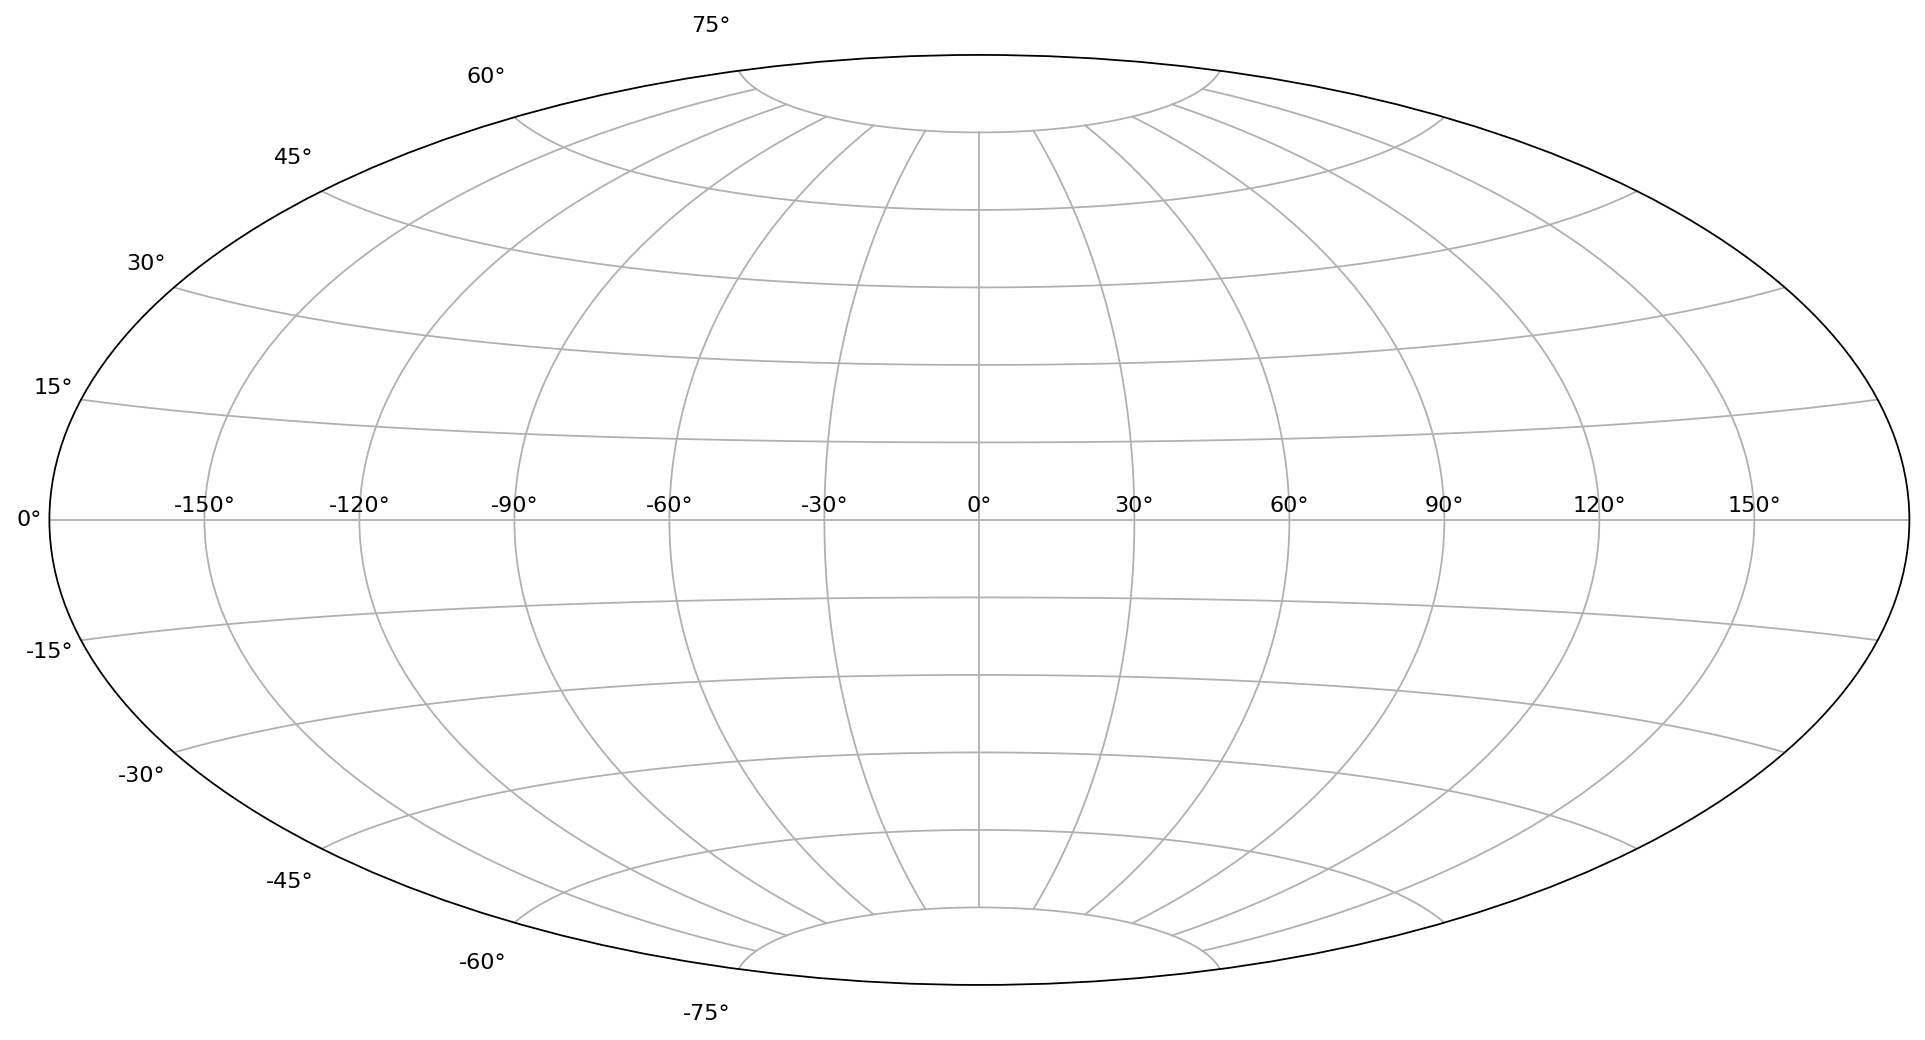

In [13]:
plt.figure(figsize=(15, 15), dpi=160)
plt.subplot(111, projection='aitoff')
plt.grid(True)
for obs in uniqueGRB.observatory_x.unique():
    tmp_pdf = uniqueGRB[uniqueGRB["observatory_x"] == obs]
    eq = SkyCoord(tmp_pdf.grb_ra, tmp_pdf.grb_dec, unit=u.deg)
    gal = eq.galactic
    
    plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, label=obs)
    plt.axhline(y=np.radians(-30), color='r', linestyle='--', label="ZTF declination limit")
    plt.legend()
    plt.show()

## Event analysis

In [14]:
eventId = "709806846"

In [15]:
event_pdf = merge_online[merge_online["triggerId"] == eventId]

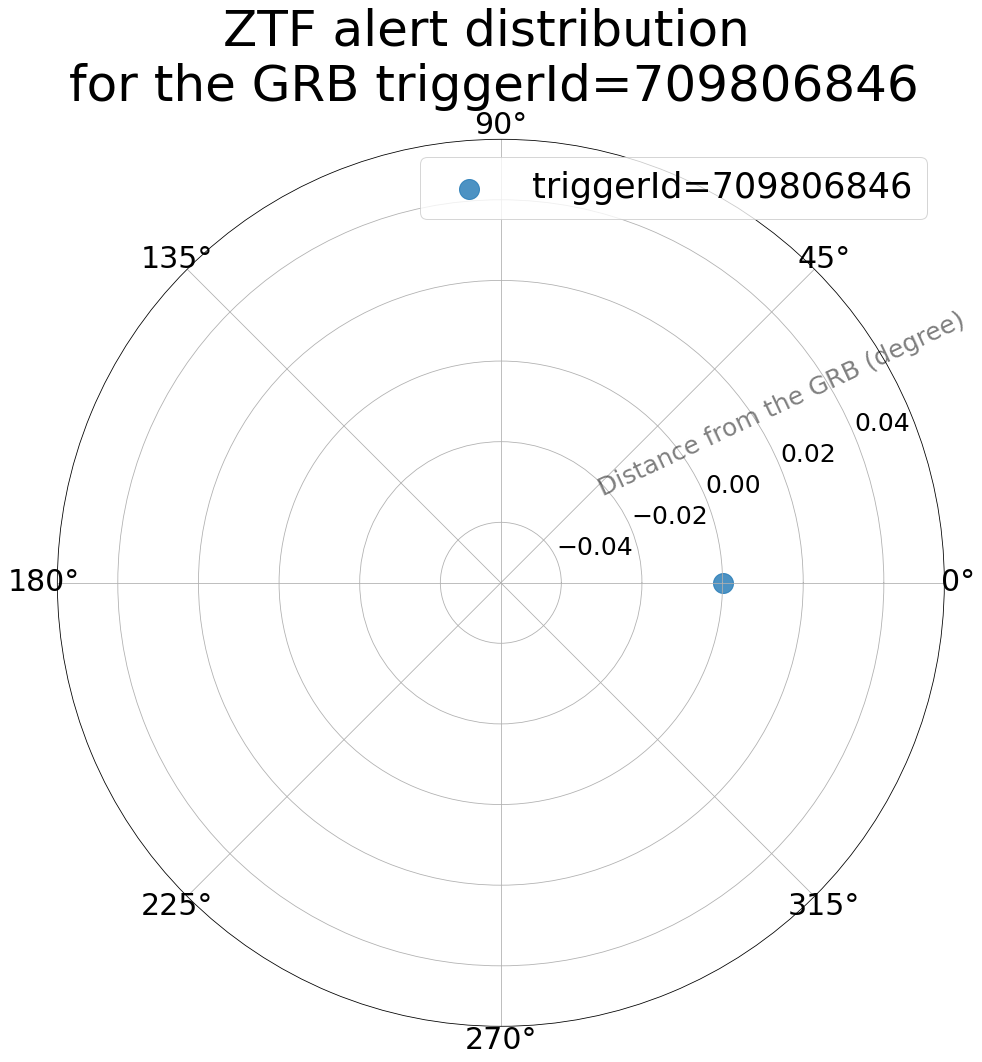

In [16]:
un.plot_ztf_join_distribution(event_pdf, eventId)

In [17]:
gold, silver = un.get_gold_and_silver(event_pdf)

In [18]:
gold

,observatory_x,instrument_x,event_x,ivorn,triggerId,ra,dec,err_arcmin,ackTime,triggerTimejd,...,fink_class,delta_mag,rate,from_upper,start_vartime,diff_vartime,timestamp,year_y,month_y,day_y
